In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.decomposition import PCA
from arch import arch_model
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/Users/balintmaroti/Documents/allianz/data/benchmark_combined.csv')

In [3]:
df

,date,settle_date,tenor,isin_code,security,maturity_date,yield,change,avg_bid_yield,avg_ask_yield,net_price,accrued_interest,source_file
0,2002-01-03,2002-01-07,3M,HU0000513379,D020417,2002-04-17,9.65,0.00,9.77,9.52,97.42560,0.0000,benchmark_01_02.xlsx
1,2002-01-03,2002-01-07,6M,HU0000513452,D020612,2002-06-12,9.39,0.00,9.50,9.27,96.14360,0.0000,benchmark_01_02.xlsx
2,2002-01-03,2002-01-07,1Y,HU0000513494,D021227,2002-12-27,8.96,0.00,9.08,8.83,92.00905,0.0000,benchmark_01_02.xlsx
3,2002-01-03,2002-01-07,3Y,HU0000402029,2004/J,2004-10-12,8.07,0.00,8.20,7.94,105.67165,4.3315,benchmark_01_02.xlsx
4,2002-01-03,2002-01-07,5Y,HU0000401963,2006/E,2006-05-12,7.58,0.00,7.70,7.45,105.16080,1.3041,benchmark_01_02.xlsx
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42101,2025-05-23,2025-05-27,3Y,HU0000405543,2028/B,2028-03-23,6.49,0.01,6.56,6.42,94.99390,0.8014,benchmark_24_25.xlsx
42102,2025-05-23,2025-05-27,5Y,HU0000403696,2030/A,2030-08-21,6.54,-0.01,6.62,6.47,84.70330,2.2932,benchmark_24_25.xlsx
42103,2025-05-23,2025-05-27,10Y,HU0000406624,2035/A,2035-10-24,7.00,0.01,7.07,6.93,99.94260,4.1233,benchmark_24_25.xlsx
42104,2025-05-23,2025-05-27,15Y,HU0000404165,2041/A,2041-04-25,7.22,-0.01,7.29,7.15,60.81900,0.2630,benchmark_24_25.xlsx


In [4]:
TENOR_ORDER = ("3M","6M","1Y","3Y","5Y","10Y","15Y","20Y")
df = df[df["tenor"].isin(TENOR_ORDER)]


In [5]:
# Building the pivot, values remain in percent points
df_pp = (df
         .groupby(["date", "tenor"])["yield"]
         .mean()                          # averages multiple quotes same day
         .unstack("tenor")                # tenor columns
         .reindex(columns=TENOR_ORDER)    # fixed order
         .sort_index()
         .ffill())

tenor,3M,6M,1Y,3Y,5Y,10Y,15Y,20Y
date,,,,,,,,
2025-05-19,6.17,6.23,6.25,6.45,6.54,6.99,7.21,7.28
2025-05-20,6.18,6.23,6.25,6.41,6.48,6.93,7.16,7.24
2025-05-21,6.24,6.23,6.26,6.49,6.57,7.00,7.23,7.31
2025-05-22,6.24,6.23,6.26,6.48,6.55,6.99,7.23,7.31
2025-05-23,6.20,6.23,6.25,6.49,6.54,7.00,7.22,7.31


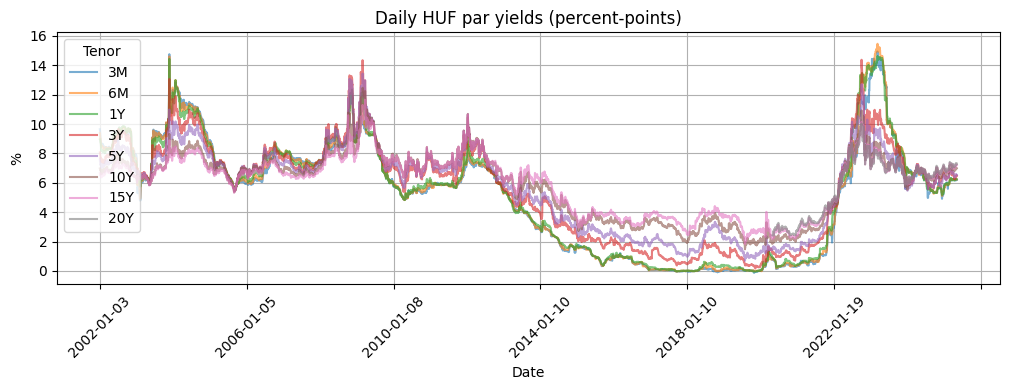

In [6]:
display(df_pp.tail())

df_pp.plot(figsize=(10,4), legend=False, alpha=0.6)
plt.title("Daily HUF par yields (percent-points)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid()
plt.legend(title="Tenor")
plt.tight_layout()
plt.ylabel("%")
plt.show()


In [7]:
# check for missing values
for col in df_pp.columns:
    if df_pp[col].isnull().any():
        print(f"Column {col} has missing values.")
    else:
        print(f"Column {col} has no missing values.")
        
        

Column 3M has no missing values.
Column 6M has no missing values.
Column 1Y has no missing values.
Column 3Y has no missing values.
Column 5Y has no missing values.
Column 10Y has no missing values.
Column 15Y has no missing values.
Column 20Y has missing values.


In [8]:
# check 20Y how many missing values
missing_20Y = df_pp['20Y'].isnull().sum()

missing_20Y

4581

In [9]:
# Dropping the 20Y column due to missing values
df_pp = df_pp.drop(columns=['20Y'])

In [10]:
df_pp

tenor,3M,6M,1Y,3Y,5Y,10Y,15Y
date,,,,,,,
2002-01-03,9.65,9.39,8.96,8.07,7.58,6.98,6.65
2002-01-04,9.59,9.36,8.94,7.98,7.48,6.96,6.60
2002-01-07,9.41,9.22,8.81,7.86,7.39,6.87,6.51
2002-01-08,9.13,8.98,8.76,7.84,7.34,6.86,6.53
2002-01-09,9.10,9.00,8.75,7.80,7.33,6.89,6.53
...,...,...,...,...,...,...,...
2025-05-19,6.17,6.23,6.25,6.45,6.54,6.99,7.21
2025-05-20,6.18,6.23,6.25,6.41,6.48,6.93,7.16
2025-05-21,6.24,6.23,6.26,6.49,6.57,7.00,7.23


In [11]:
# save to csv
# df_pp.to_csv('/Users/balintmaroti/Documents/allianz/data/benchmark_pivot.csv')